<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/24-keras-part-2/stateful_rnn_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stateful RNN Fundamentals

We’ve been focusing on one sample at a time, but in practice we usually
train in mini-batches. This poses an interesting question for RNNs,
since their internal memory is always influenced by previous inputs.
When should we clear that memory and let the RNN start over?

The usual approach is to clear the internal memory at the start of a
new batch, or mini-batch. We don’t clear or reset the weights belonging
to the neurons inside the RNN, since those tell it how to do its job.
We only clear its changing memory that holds the inputs it’s recently
seen. 

The thinking is that when a new batch begins we’ll possibly be
getting data that isn’t a continuation of the most recent samples, so we
don’t want to remember stuff from back then.

Usually, we shuffle our samples between epochs, so they arrive in an
unpredictable order each time. 

But we can keep their order consistent from epoch to epoch, if we want to. We do this when we call fit() to train our model, setting the optional argument shuffle to False (the default is True).

When the data is always arriving in sequence, there’s no reason to reset
the memory at the start of each batch, because those samples follow
the samples in the previous batch. 

In other words, the batching just breaks up the grouping of the samples, and not their sequence. In that situation, we can tell Keras to not reset the memory at the start of each batch. This sometimes can help us train a little faster.

In Keras, when we take over the responsibility for clearing the memory
we say that the RNN is in the stateful mode. In this mode, Keras
only resets the internal state when we tell it to. Usually this is at the
start (or end) of each epoch.

Stateful mode can make training go a little faster, but it comes with
limitations. The batch size must be determined in advance, and it
becomes a part of the model. The dataset must be a multiple of this
batch size.

For instance, if the batch size is 100, the dataset must be
100, 200, 300, and so on samples long. If it’s 130 or 271 samples, we’ll
get an error.

When we later give new data to the model for it to evaluate, that data
also has to come in batches of the same size we used when we trained.
If we want only one prediction, but our batch size is 100, then we can
either pad out our one request with 99 more copies of itself, or just
load up all the unused entries in the batch with 0’s. We’ll still end up
waiting for the network to evaluate all those samples, though.

To make a stateful network, we need to do four things.

* First, we need to include the optional argument stateful to each RNN
(such as an LSTM or GRU) and set it to True. This tells Keras that
we’re taking care of when to reset the cell’s state.

* Second, we need to include the argument batch_size to the first RNN
we make, and set it to the batch size that we’re going to use during
training.

* Third, when we call fit() we need to set shuffle to False.

* Finally, when we want to reset the state, we need to explicitly call
reset_states() on our model.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

keras_backend.set_image_data_format('channels_last')

TensorFlow 2.x selected.


## Creating the Training Dataset

First, let’s generates uniform random data between -amp and +amp and of length xn.

Reference: https://github.com/keras-team/keras/blob/master/examples/lstm_stateful.py

In [0]:
# ----------------------------------------------------------
# EDITABLE PARAMETERS
# ----------------------------------------------------------

# length of input
input_len = 1000

# The window length of the moving average used to generate
# the output from the input in the input/output pair used
# to train the LSTM
# e.g. if tsteps=2 and input=[1, 2, 3, 4, 5],
#      then output=[1.5, 2.5, 3.5, 4.5]
tsteps = 2

# The input sequence length that the LSTM is trained on for each output point
lahead = 1

# training parameters passed to "model.fit(...)"
batch_size = 1
epochs = 10

In [0]:
def gen_uniform_amp(amp=1, xn=10000):
    """Generates uniform random data between
    -amp and +amp
    and of length xn
    # Arguments
        amp: maximum/minimum range of uniform data
        xn: length of series
    """
    data_input = np.random.uniform(-1 * amp, +1 * amp, xn)
    data_input = pd.DataFrame(data_input)
    return data_input

In [0]:
to_drop = max(tsteps - 1, lahead - 1)
data_input = gen_uniform_amp(amp=0.1, xn=input_len + to_drop)

# set the target to be a N-point average of the input
expected_output = data_input.rolling(window=tsteps, center=False).mean()

# when lahead > 1, need to convert the input to "rolling window view"
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html
if lahead > 1:
    data_input = np.repeat(data_input.values, repeats=lahead, axis=1)
    data_input = pd.DataFrame(data_input)
    for i, c in enumerate(data_input.columns):
        data_input[c] = data_input[c].shift(i)

# drop the nan
expected_output = expected_output[to_drop:]
data_input = data_input[to_drop:]

Plotting input and expected output


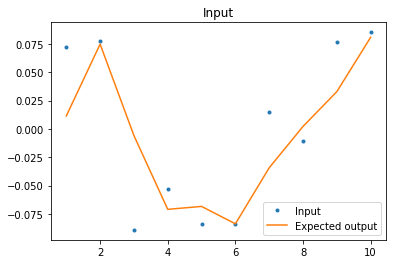

In [22]:
print('Plotting input and expected output')
plt.plot(data_input[0][:10], '.')
plt.plot(expected_output[0][:10], '-')
plt.legend(['Input', 'Expected output'])
plt.title('Input')
plt.show()

## Stateful RNN Model

Now let’s create the stateful RNN. 

First, we need to set stateful=True when creating every recurrent layer. 

Second, the stateful RNN needs to know the batch size (since it
will preserve a state for each input sequence in the batch), so we must set the batch_input_shape argument in the first layer.

Note that we can leave the second dimension unspecified, since the inputs could have any length.

In [0]:
model = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, stateful=True, input_shape=(lahead, 1), batch_size=batch_size),
    keras.layers.LSTM(50, stateful=True),
    keras.layers.Dense(1)                             
])

In [24]:
# split train/test data
def split_data(x, y, ratio=0.8):
    to_train = int(input_len * ratio)
    # tweak to match with batch_size
    to_train -= to_train % batch_size

    x_train = x[:to_train]
    y_train = y[:to_train]
    x_test = x[to_train:]
    y_test = y[to_train:]

    # tweak to match with batch_size
    to_drop = x.shape[0] % batch_size
    if to_drop > 0:
        x_test = x_test[:-1 * to_drop]
        y_test = y_test[:-1 * to_drop]

    # some reshaping
    reshape_3 = lambda x: x.values.reshape((x.shape[0], x.shape[1], 1))
    x_train = reshape_3(x_train)
    x_test = reshape_3(x_test)

    reshape_2 = lambda x: x.values.reshape((x.shape[0], 1))
    y_train = reshape_2(y_train)
    y_test = reshape_2(y_test)

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = split_data(data_input, expected_output)
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (800, 1, 1)
y_train.shape:  (800, 1)
x_test.shape:  (200, 1, 1)
y_test.shape:  (200, 1)


To train our model, we need to remember to tell fit() not to shuffle
our data. Because we want to reset the state after each epoch, we don’t
want to do the usual thing of telling fit() how many epochs to train
for, and then walking away, because then the RNN will never be reset.

Instead, we’ll tell fit() to train for only 1 epoch, and we’ll put that call
in a loop. The loop will repeat for the number of epochs we want to
train for. Doing it this way lets us put in a call to reset_states() at
the end of each epoch of training.

In [25]:
model.compile(loss='mse', optimizer='adam')

for epoch in range(50):
  model.fit(x_train, y_train, epochs=1, batch_size=batch_size, shuffle=False, validation_data=(x_test, y_test), verbose=1)
  model.reset_states()

Train on 800 samples, validate on 200 samples
800/800 [==============================] - 5s 7ms/sample - loss: 5.3910e-04 - val_loss: 3.0246e-04
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 3s 3ms/sample - loss: 3.0988e-04 - val_loss: 3.0565e-04
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 3s 3ms/sample - loss: 3.2430e-04 - val_loss: 3.1926e-04
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 3s 3ms/sample - loss: 3.4284e-04 - val_loss: 3.3060e-04
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 3s 4ms/sample - loss: 3.5289e-04 - val_loss: 3.1926e-04
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 3s 4ms/sample - loss: 3.4639e-04 - val_loss: 2.9675e-04
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 3s 4ms/sample - loss: 3.4605e-04 - val_lo